Francisco José Durá Galiana

# Red H2V para predicción de tempo

In [2]:
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

import os
import keras
import h5py
import librosa
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import seaborn as sns

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [3]:
# Parámetros de extracción de canciones
gtzan_dir = r"D:\Users\franc\Documents\IMF - Deep Learning\Trabajo Master\Datasets\GTZAN\genres"
data_df = pd.read_csv(r"D:\Users\franc\Documents\IMF - Deep Learning\Trabajo Master\Scripts\gtzan_clean.csv")
song_samples = 660000
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}
tempos = {'('+str(t)+', '+str(t+10)+']':i 
          for i,t in enumerate(range(data_df.tempo.astype(int).min(),data_df.tempo.astype(int).max(),10))}

In [4]:
# X = np.load('x_gtzan_npy.npy')
X = np.load('x_db_scaled.npy')
y1 = np.load('y1_gtzan_npy.npy')
# y2 = np.load('y2_gtzan_npy.npy')
y2 = np.load('y2_binned.npy')

Finalmente convertimos la variable de target a una variable one-hot para poder utilizar en la capa de salida de la red como clasificación categórica:

In [5]:
y1 = to_categorical(y1)

In [6]:
y2 = to_categorical(y2)

## Partición de los datos
A continuación se procede a la partición de los datos en sets de entrenamiento y validación. Originalmente se utilizaba un split de 70/30 de entrenamiento y validación, pero vamos a utilizar un split de entrenamiento/test de 80/20 y utilizaremos un 25% del entrenamiento para validación.

In [9]:
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler

In [11]:
y = np.concatenate((y1,y2),axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [13]:
y1_train = y_train[:,:10]
y1_test = y_test[:,:10]
y2_train = y_train[:,10:]
y2_test = y_test[:,10:]

In [14]:
print(X_train.shape, X_test.shape)
print(y1_train.shape, y1_test.shape)
print(y2_train.shape, y2_test.shape)

(15200, 128, 129, 1) (3800, 128, 129, 1)
(15200, 10) (3800, 10)
(15200, 13) (3800, 13)


Para comprobar que la distribución de las categorías es equitativa entre los sets pintamos el siguiente gráfico de barras:

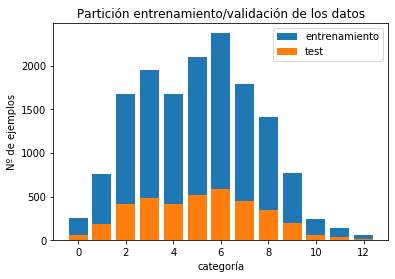

In [16]:
# Histogram for train and test 
values, count = np.unique(np.argmax(y2_train, axis=1), return_counts=True)
plt.bar(values, count, label='entrenamiento')

values, count = np.unique(np.argmax(y2_test, axis=1), return_counts=True)
plt.bar(values, count, label='test')
plt.title('Partición entrenamiento/validación de los datos')
plt.xlabel('categoría')
plt.ylabel('Nº de ejemplos')
plt.legend()
plt.show()

## Construcción del modelo

In [17]:
# Model Definition
class MIR:
    
    def build(num_genres=10,num_tempos=13):
        input_shape = X_train[0].shape

        inputs = Input(shape=input_shape)
        # Conv Block 1
        x1 = Conv2D(32, kernel_size=(24,1), strides=(1, 1), activation='relu', name='CV11')(inputs)
        x1 = MaxPooling2D(pool_size=(3, 1), strides=(2, 1), name='PV11')(x1)
        x1 = Dropout(0.25, name='DV11')(x1)

        # Conv Block 1
        x2 = Conv2D(32, kernel_size=(24,1), strides=(1, 1), activation='relu', name='CV21')(x1)
        x2 = MaxPooling2D(pool_size=(3, 1), strides=(2, 1), name='PV21')(x2)
        x2 = Dropout(0.25, name='DV21')(x2)

        # Conv Block H2
        x3 = Conv2D(64, kernel_size=(2,8), strides=(1, 1), activation='relu', name='CH1')(x2)
        x3 = MaxPooling2D(pool_size=(1, 2), strides=(1, 2), name='PH1')(x3)
        x3 = Dropout(0.25, name='DH1')(x3)

        # Conv Block H2
        x3 = Conv2D(64, kernel_size=(2,8), strides=(1, 1), activation='relu', name='CH2')(x3)
        x3 = MaxPooling2D(pool_size=(1, 2), strides=(1, 2), name='PH2')(x3)
        x3 = Dropout(0.25, name='DH2')(x3)

        # Conv Block V1
        x4 = Conv2D(128, kernel_size=(2, 8), strides=(1, 1), activation='relu', name='CH3')(x3)
        x4 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='PH3')(x4)
        x4 = Dropout(0.25, name='DH3')(x4)

        # Conv Block V2
        x5 = Conv2D(64, kernel_size=(2, 2), strides=(1, 1), activation='relu', name='C1')(x4)
        x5 = MaxPooling2D(pool_size=(4, 4), strides=(4, 4), name='P1')(x5)
        x5 = Dropout(0.5, name='D1')(x5)

        # MLP
        y = Flatten(name='V_out')(x5)
        
        y2 = Dense(32, activation='relu')(y)
        y2 = Dense(16, activation='relu')(y2)
        y2 = Dense(num_tempos, activation='softmax',name="tempo")(y)

        model = Model(
            inputs=inputs,
            outputs=y2,
            name="MIR")
        
        return model

In [18]:
model = MIR.build()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 129, 1)       0         
_________________________________________________________________
CV11 (Conv2D)                (None, 105, 129, 32)      800       
_________________________________________________________________
PV11 (MaxPooling2D)          (None, 52, 129, 32)       0         
_________________________________________________________________
DV11 (Dropout)               (None, 52, 129, 32)       0         
_________________________________________________________________
CV21 (Conv2D)                (None, 29, 129, 32)       24608     
_________________________________________________________________
PV21 (MaxPooling2D)          (None, 14, 129, 32)       0         
_________________________________________________________________
DV21 (Dropout)               (None, 14, 129, 32)       0         
__________

## Entrenamiento del modelo

In [20]:
optimizer = keras.optimizers.RMSprop(0.001)

model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [21]:
tensorboard = TensorBoard(log_dir='./logs/scalars/tempo4_binned_fixed', histogram_freq=0, write_graph=True)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10)

hist = model.fit(X_train, y2_train,
          batch_size=32, # tamaño del batch de entrenamiento
          epochs=200, # Número de pases
          verbose=1, # Mostrar progreso
          validation_split=0.25,
          callbacks=[tensorboard, earlystop]) # Seleccionar un 25% de los datos para validación 

Train on 11400 samples, validate on 3800 samples
Epoch 1/200
11400/11400 [==============================] - 13s 1ms/step - loss: 2.4054 - acc: 0.1402 - val_loss: 2.3034 - val_acc: 0.1708
Epoch 2/200
11400/11400 [==============================] - 11s 963us/step - loss: 2.2765 - acc: 0.1552 - val_loss: 2.3178 - val_acc: 0.1329
Epoch 3/200
11400/11400 [==============================] - 11s 1ms/step - loss: 2.2100 - acc: 0.1912 - val_loss: 2.1477 - val_acc: 0.1950c: 0.185 - ETA: 1s - lo - ETA: 0s - loss: 2.2124 - acc - ETA: 0s - loss: 2.2104 - acc: 0.19
Epoch 4/200
11400/11400 [==============================] - 11s 994us/step - loss: 2.0303 - acc: 0.2823 - val_loss: 1.8153 - val_acc: 0.3839
Epoch 5/200
11400/11400 [==============================] - 11s 995us/step - loss: 1.8590 - acc: 0.3617 - val_loss: 1.7619 - val_acc: 0.4087
Epoch 6/200
11400/11400 [==============================] - 11s 995us/step - loss: 1.6841 - acc: 0.4411 - val_loss: 1.8386 - val_acc: 0.40716 - acc: 
Epoch 7/200
114

## Resultados

In [22]:
score_test = model.evaluate(X_test, y2_test, verbose=0)
print("\t\t|-----------|-------|")
print("\tTempo\t| Precisión | Coste |")
print("+---------------+-----------+-------+")
print("| Entrenamiento\t|   {:5.3f}   | {:5.2f} |".format(hist.history['acc'][-1], hist.history['loss'][-1]))
print("| Validacion\t|   {:5.3f}   | {:5.2f} |".format(hist.history['val_acc'][-1], hist.history['val_loss'][-1]))
print("| Test\t\t|   {:5.3f}   | {:5.2f} |".format(score_test[1], score_test[0]))
print("+---------------+-----------+-------+")

		|-----------|-------|
	Tempo	| Precisión | Coste |
+---------------+-----------+-------+
| Entrenamiento	|   0.566   |  1.34 |
| Validacion	|   0.563   |  1.33 |
| Test		|   0.574   |  1.32 |
+---------------+-----------+-------+


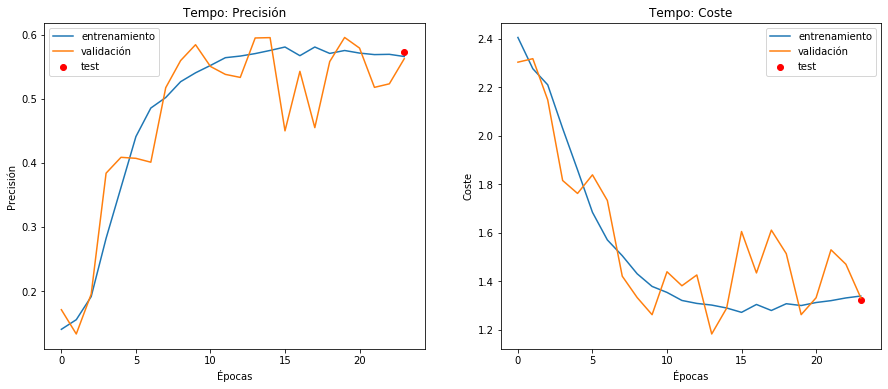

In [23]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(hist.history['acc'], label='entrenamiento')
plt.plot(hist.history['val_acc'], label='validación')
plt.scatter(x=len(hist.history['acc'])-1, y = score_test[1], c='red',label='test')
plt.title('Tempo: Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='entrenamiento')
plt.plot(hist.history['val_loss'], label='validación')
plt.scatter(x=len(hist.history['loss'])-1, y = score_test[0], c='red',label='test')
plt.title('Tempo: Coste')
plt.xlabel('Épocas')
plt.ylabel('Coste')
plt.legend()

Utilizamos los datos de test para generar la matriz de confusión

In [39]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y2_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

In [41]:
keys = OrderedDict(sorted(tempos.items(), key=lambda t: t[1])).keys() # extraer nombres de categorías

In [43]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Si se elige normalize=True los valores de las filas se normalizaran
    if normalize:
        # normalizar sobre las filas (valores verdaderos)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # generar gráfico
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    # Generar ejes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Añadir anotaciones a celdas
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

C:\Users\franc\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


Normalized confusion matrix


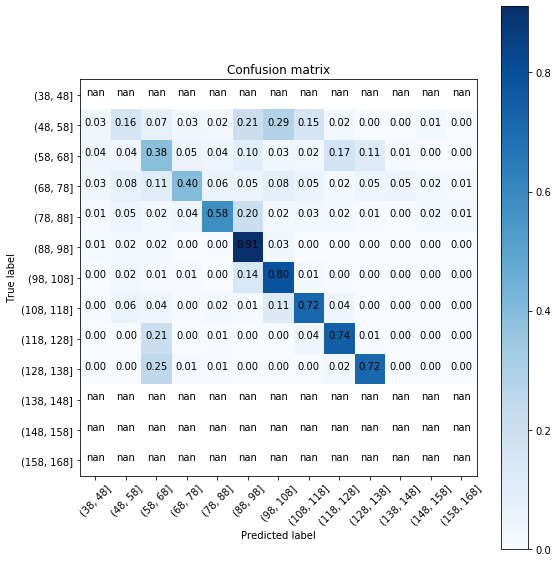

In [44]:
plt.figure(figsize=(8,8)) 
plot_confusion_matrix(cm, keys, normalize=True)

Los valores NaN se deben a que esos valores no se han predecido en ningun momento y se divide por 0 en la matriz de confusión (ya que se divide por cada fila)

## Save the model
En el caso de que quisieramos guardar el modelo con sus pesos entrenados para uso futuro podemos utilizar la función `save()`:

In [28]:
# Save the model
# model.save('../models/nbs_deeplearning.h5')